In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models.linear_regression import MyLinearRegression
from sklearn.linear_model import LinearRegression
from metrics import *

In [2]:
medical_cost_data = pd.read_csv("insurance.csv")
medical_cost_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


***Data:***
* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of children covered by health insurance / Number of dependents
* smoker: Smoking
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: Individual medical costs billed by health insurance

In [3]:
medical_cost_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
medical_cost_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
medical_cost_data.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [6]:
medical_cost_data.sex = medical_cost_data.sex.map(dict(male = 1, female=0))
medical_cost_data.smoker = medical_cost_data.smoker.map(dict(yes = 1, no = 0))
medical_cost_data = pd.get_dummies(medical_cost_data, columns = ["region"])
medical_cost_data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


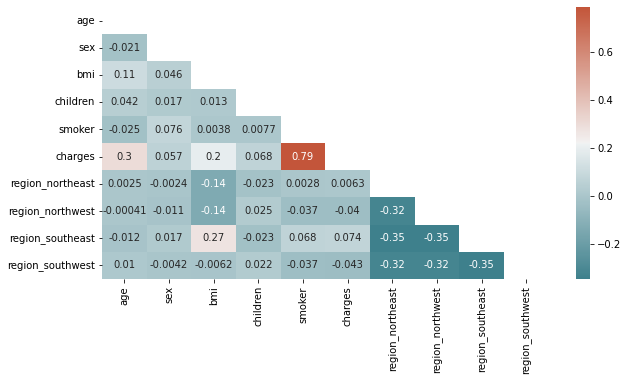

In [7]:
correlation = medical_cost_data.corr()
cmap = sns.diverging_palette(210, 20, as_cmap=True)
mask = np.triu(np.ones_like(correlation,dtype = bool))
plt.figure(figsize = (10,5))
ax = sns.heatmap(correlation, cmap = cmap, annot = True, mask = mask)
plt.show()

Only "smoker" feature is highly correlated with target variable "charges".<br>I am a little bit surprised, because I thought, that age and body mass index will have a higher correlation with the target.

In [8]:
sns.set_theme(style="ticks")

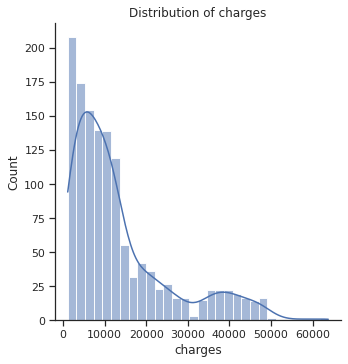

In [9]:
plot = sns.displot(x = "charges", data = medical_cost_data, kde = True)
plt.title("Distribution of charges")
plt.show()

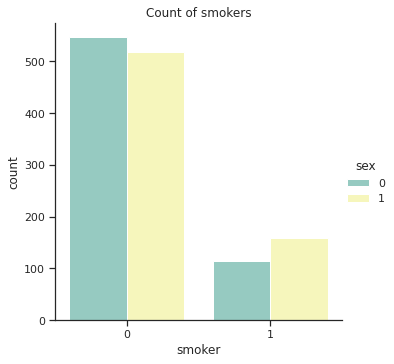

In [10]:
sns.catplot(x="smoker", hue = "sex",kind="count",data= medical_cost_data, palette = "Set3")
plt.title("Count of smokers")
plt.show()

As we can see there are more non-smokers, and males smoke a little more often than females.

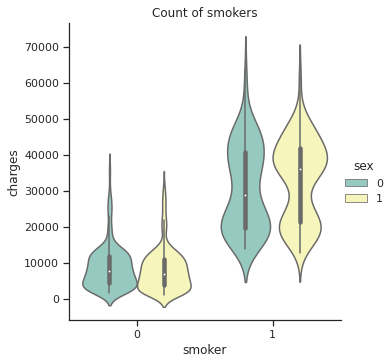

In [11]:
sns.catplot(x="smoker", y ="charges",hue = "sex",kind="violin",data= medical_cost_data, palette = "Set3")
plt.title("Count of smokers")
plt.show()

Logically smokers spend more money on treatment.

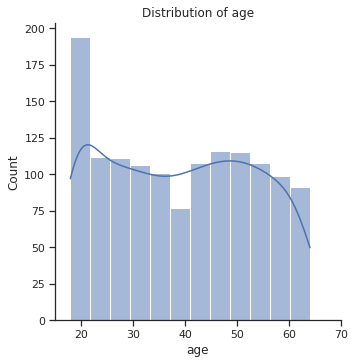

In [12]:
sns.displot(x = "age", data = medical_cost_data, kde = True)
plt.title("Distribution of age")
plt.xlim(15,70)
plt.show()

In [13]:
medical_cost = medical_cost_data.copy()

Let's create a new column with category, that depends on the age of patient

In [14]:
def age_category(age):
    if age >= 18 and age <21:
        return "Teen"
    elif age < 40:
        return "Young Adult"
    elif age < 60:
        return "Middle Adult"
    else:
        return "Old"

In [15]:
medical_cost_data["age_category"] = medical_cost_data.age.apply(age_category)

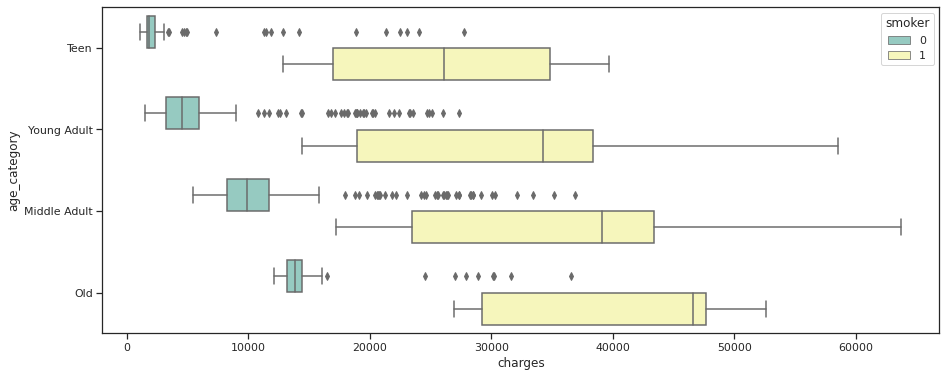

In [16]:
plt.figure(figsize=(15,6))
sns.boxplot(x="charges",y="age_category",hue = "smoker", data = medical_cost_data, palette = 'Set3')
plt.show()

Smoker teens spend much more money on treatment than same age non-smokers

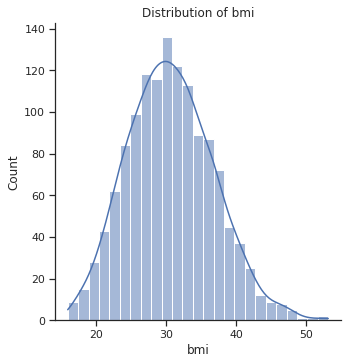

In [17]:
sns.displot(x = "bmi", data = medical_cost_data, kde = True)
plt.title("Distribution of bmi")
plt.show()

The "bmi" parameter is normal distributed with mean = 30

Let's create a new column with category, that depends on the bmi of patient

In [18]:
def bmi_category(bmi):
    if bmi<18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    elif bmi < 35:
        return "Obese"
    else:
        return "Extremely Obese"

In [19]:
medical_cost_data["bmi_category"] = medical_cost_data.bmi.apply(bmi_category)
medical_cost_data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,age_category,bmi_category
0,19,0,27.900,0,1,16884.92400,0,0,0,1,Teen,Overweight
1,18,1,33.770,1,0,1725.55230,0,0,1,0,Teen,Obese
2,28,1,33.000,3,0,4449.46200,0,0,1,0,Young Adult,Obese
3,33,1,22.705,0,0,21984.47061,0,1,0,0,Young Adult,Normal
4,32,1,28.880,0,0,3866.85520,0,1,0,0,Young Adult,Overweight


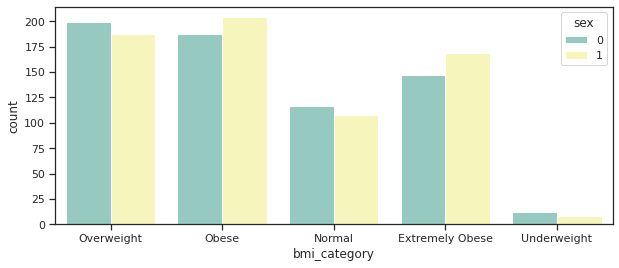

In [20]:
plt.figure(figsize=(10,4))
sns.countplot(x="bmi_category", hue = "sex", data = medical_cost_data, palette = 'Set3')
plt.show()

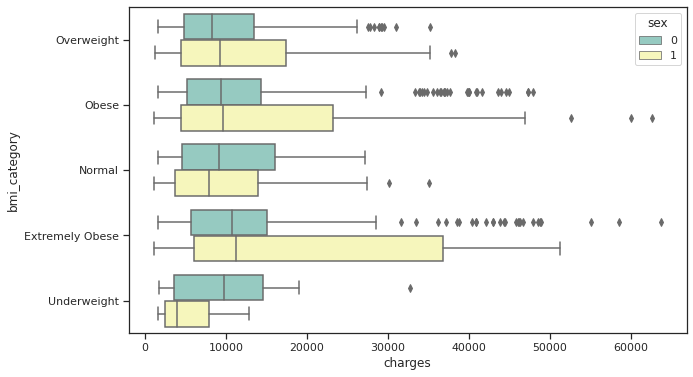

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(x="charges",y="bmi_category", hue = "sex", data = medical_cost_data, palette = 'Set3')
plt.show()

Normal, Overweight and Obese people spend +- equal money amount for treatment.
Interesting fact, that Underweight females spend more money than males.I reckon, the reason is that in there are female with Anorexia and another psychological disorders, whereas it's a genetic factor in male group.

In [48]:
X = medical_cost.drop("charges", axis = 1)
y = medical_cost["charges"].values

X_standart = ((X - np.mean(X))/ np.std(X))
X_stand_shuffled = X_standart.sample(frac = 1)
y_shuffled = y[X_stand_shuffled.index]


X_train, X_test = np.split(X_stand_shuffled, [int(0.8 * len(y_shuffled))])
y_train, y_test = np.split(y_shuffled, [int(0.8 * len(y_shuffled))])

In [49]:
X_train.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
554,-1.011557,-1.010519,1.748977,-0.908614,-0.507463,1.769076,-0.566418,-0.611324,-0.566418
703,-0.370746,-1.010519,-0.697746,-0.078767,-0.507463,-0.565267,1.765481,-0.611324,-0.566418
521,-0.513149,-1.010519,2.223886,-0.908614,-0.507463,-0.565267,-0.566418,1.635795,-0.566418
29,-0.584350,0.989591,0.924654,0.751079,1.970587,-0.565267,-0.566418,-0.611324,1.765481
1258,1.124479,0.989591,1.156777,1.580926,-0.507463,-0.565267,1.765481,-0.611324,-0.566418


In [50]:
my_linear = MyLinearRegression(learning_rate = 0.1, max_iterations = 100, regularization_term = 0.1)
my_linear_history = my_linear.fit(X_train,y_train, X_cv, y_cv, metrics = [], report_periodicity = 20)


0/100: Loss -> 162280989.535
20/100: Loss -> 20326076.105
40/100: Loss -> 18123490.589
60/100: Loss -> 18084951.098
80/100: Loss -> 18084200.261
100/100: Loss -> 18084183.383

In [51]:
y_test_pred = my_linear.predict(X_test)

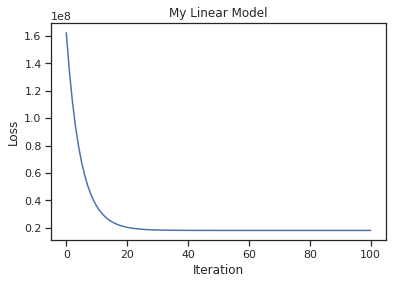

In [52]:
figure = sns.lineplot(x = my_linear_history.keys(), y = my_linear_history.values())
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("My Linear Model")
plt.show(figure)

In [53]:
mse(y_test,y_test_pred)

38248527.015626155